In [1]:
from google.colab import files
uploaded = files.upload()

Saving US_Original_dataset_final.zip to US_Original_dataset_final.zip


In [2]:
import zipfile
import io
data = zipfile.ZipFile(io.BytesIO(uploaded['US_Original_dataset_final.zip']), 'r')
data.extractall()

In [3]:
import os
from PIL import Image

Resize images for Xception

In [4]:
def resizeAndSave(file_name):
  img_size=(299,299)  
  img = Image.open(file_name) 
  img = img.resize(img_size, Image.ANTIALIAS)  
  img.save(file_name)

In [5]:
benign_path = 'Benign/'
malignant_path = 'Malignant/'

In [6]:
#Resize images
def resizeDirectory(folder):
  folder_path = '/content/US_Original_dataset_final/'+folder+'/' 
  folder_b = folder_path + benign_path
  folder_m = folder_path + malignant_path

  mytrainBImages = os.listdir(folder_b)
  mytrainMImages = os.listdir(folder_m)

  for cl in mytrainBImages:
    file_nameb = folder_b + cl 
    resizeAndSave(file_nameb)    

  for cl in mytrainMImages:
    file_namem = folder_m + cl 
    resizeAndSave(file_namem)

In [7]:
resizeDirectory('test')
resizeDirectory('train')
resizeDirectory('validation')

In [8]:
train_path = '/content/US_Original_dataset_final/train'
test_path = '/content/US_Original_dataset_final/test'
val_path = '/content/US_Original_dataset_final/validation'



---
Common functions


In [9]:
classes = ['Benign', 'Malignant']

In [10]:
from matplotlib import pyplot
def summarize_diagnostics(history):
  # plot loss
  pyplot.figure(0)
  pyplot.title('Loss')
  pyplot.plot(history.history['loss'], color='blue', label='train')
  pyplot.plot(history.history['val_loss'], color='orange', label='test')
  pyplot.legend(['loss','val_loss']) 

  # plot accuracy
  pyplot.figure(1)
  pyplot.title('Classification Accuracy')
  pyplot.plot(history.history['accuracy'], color='blue', label='train')
  pyplot.plot(history.history['val_accuracy'], color='orange', label='test')
  pyplot.legend(['accuracy','val_accuracy'])

In [11]:
#functions to build confusion matrix
from tqdm import tqdm
import os
import cv2
import numpy as np
import itertools
from sklearn.metrics import accuracy_score, confusion_matrix

def load_data(dir_path):
    """
    Load resized images as np.arrays to workspace
    """
    X = []
    y = []
    i = 0
    labels = dict()
    for path in tqdm(sorted(os.listdir(dir_path))):
        if not path.startswith('.'):
            labels[i] = path
            for file in os.listdir(dir_path + path):
                if not file.startswith('.'):
                    img = cv2.imread(dir_path + path + '/' + file)
                    X.append(img)
                    y.append(i)
            i += 1
    X = np.array(X)
    y = np.array(y)
    print(f'{len(X)} images loaded from {dir_path} directory.')
    return X, y, labels



def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=pyplot.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    pyplot.figure(figsize = (6,6))
    pyplot.imshow(cm, interpolation='nearest', cmap=cmap)
    pyplot.title(title)
    pyplot.colorbar()
    tick_marks = np.arange(len(classes))
    pyplot.xticks(tick_marks, classes, rotation=90)
    pyplot.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    cm = np.round(cm,2)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        pyplot.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    pyplot.tight_layout()
    pyplot.ylabel('True label')
    pyplot.xlabel('Predicted label')
    pyplot.show()

x_test, y_test, labels = load_data('/content/US_Original_dataset_final/test/')
print(labels)

100%|██████████| 2/2 [00:00<00:00, 19.54it/s]

40 images loaded from /content/US_Original_dataset_final/test/ directory.
{0: 'Benign', 1: 'Malignant'}


In [12]:
from sklearn.metrics import classification_report
def validateResults(model):   
  predictions = model.predict(x_test, batch_size=batch_size)
  y_pred = np.argmax(predictions, axis=1) 
  y_true = np.argmax(y_test, axis=0)

  print("\n"+ classification_report(y_test, y_pred, target_names=classes))
  print(confusion_matrix(y_test, y_pred))
  confusion_mtx = confusion_matrix(y_test, y_pred)
  cm = plot_confusion_matrix(confusion_mtx, classes = list(labels.items()), normalize=False)

Xception

In [13]:
import cv2
from PIL import Image
import numpy as np

In [14]:
from tensorflow.keras.optimizers import SGD
from keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau
from keras.applications.xception import Xception
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator

In [15]:
from tensorflow import keras
# define cnn model
def BuildXception():
  # load model
  base_model = keras.applications.Xception(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(299, 299, 3),
    include_top=False) 

  base_model.trainable = False 

  inputs = keras.Input(shape=(299, 299, 3))
  # We make sure that the base_model is running in inference mode here,
  # by passing `training=False`. This is important for fine-tuning, as you will
  # learn in a few paragraphs.
  x = base_model(inputs, training=False)
  # Convert features of shape `base_model.output_shape[1:]` to vectors
  x = keras.layers.GlobalAveragePooling2D()(x)
  # A Dense classifier 
  outputs = keras.layers.Dense(2)(x)
  model = keras.Model(inputs, outputs)

  return model

In [16]:
modelXception = BuildXception()
modelXception.summary()

83697664/83683744 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 299, 299, 3)]     0         
                                                                 
 xception (Functional)       (None, 10, 10, 2048)      20861480  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 2)                 4098      
                                                                 
Total params: 20,865,578
Trainable params: 4,098
Non-trainable params: 20,861,480
_________________________________________________________________


In [34]:
EPOCHS = 50
batch_size=32
es = EarlyStopping(monitor='val_loss', patience=30, verbose=1, min_delta=1e-4)
rlrop = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4, verbose=1, min_delta=1e-4)

In [35]:
datagen = ImageDataGenerator(rescale=1./255, rotation_range = 5, width_shift_range = 0.1, 
                               height_shift_range = 0.1, horizontal_flip = True)

train_it = datagen.flow_from_directory(train_path, batch_size=batch_size, target_size=(299, 299))
validation_it = datagen.flow_from_directory(val_path, batch_size=batch_size, target_size=(299, 299))
test_it = datagen.flow_from_directory(test_path, batch_size=batch_size, target_size=(299, 299))

Found 98 images belonging to 2 classes.
Found 25 images belonging to 2 classes.
Found 40 images belonging to 2 classes.


In [36]:
from keras import callbacks
def fitXceptionv1():
  modelv1 = BuildXception()
  modelv1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

  # fit model
  historyXcep_v1 = modelv1.fit(
      train_it, 
      steps_per_epoch=len(train_it),
      validation_data=validation_it, 
      validation_steps=len(validation_it), 
      epochs=EPOCHS, 
      verbose=1,
      callbacks = [rlrop, es])
  
  return historyXcep_v1, modelv1

In [37]:
historyXcep_v1, modelv1 = fitXceptionv1()

Epoch 1/50
4/4 [==============================] - 7s 1s/step - loss: 0.9002 - accuracy: 0.6020 - val_loss: 0.6512 - val_accuracy: 0.6000 - lr: 0.0010
Epoch 2/50
4/4 [==============================] - 3s 735ms/step - loss: 0.6395 - accuracy: 0.6633 - val_loss: 0.6356 - val_accuracy: 0.6800 - lr: 0.0010
Epoch 3/50
4/4 [==============================] - 3s 686ms/step - loss: 0.6145 - accuracy: 0.7347 - val_loss: 0.6641 - val_accuracy: 0.6000 - lr: 0.0010
Epoch 4/50
4/4 [==============================] - 3s 950ms/step - loss: 0.6020 - accuracy: 0.7551 - val_loss: 0.6443 - val_accuracy: 0.6400 - lr: 0.0010
Epoch 5/50
4/4 [==============================] - 3s 967ms/step - loss: 0.5889 - accuracy: 0.7347 - val_loss: 0.6463 - val_accuracy: 0.6000 - lr: 0.0010
Epoch 6/50
4/4 [==============================] - ETA: 0s - loss: 0.5739 - accuracy: 0.7143
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
4/4 [==============================] - 3s 738ms/step - loss: 0.5739 -

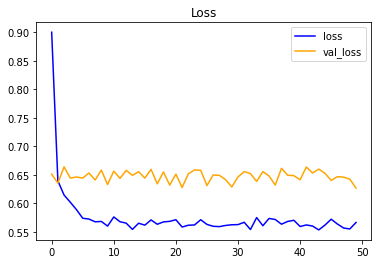

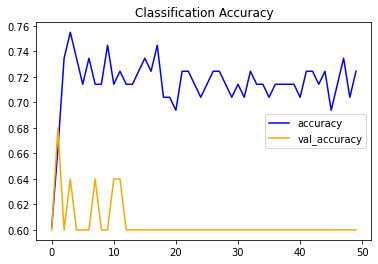

In [38]:
summarize_diagnostics(historyXcep_v1)


              precision    recall  f1-score   support

      Benign       0.64      0.81      0.71        26
   Malignant       0.29      0.14      0.19        14

    accuracy                           0.57        40
   macro avg       0.46      0.48      0.45        40
weighted avg       0.51      0.57      0.53        40

[[21  5]
 [12  2]]


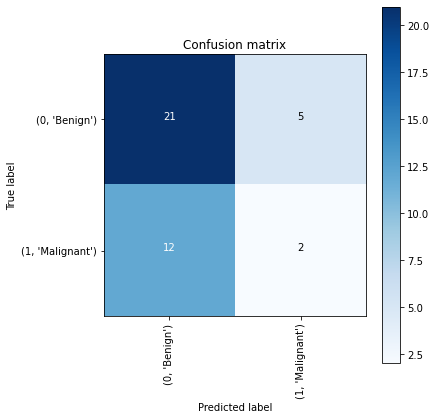

In [39]:
validateResults(modelv1)

In [ ]:
#gráfico compartido accuracy
#pyplot.figure()
#pyplot.plot(historyAlexNet1.history['accuracy'], label = 'AlexNet1')
#pyplot.plot(historyAlexNet2.history['accuracy'], label = 'AlexNet2')
#pyplot.plot(historyAlexNet3.history['accuracy'], label = 'AlexNet3')
#pyplot.xlabel("Number of Epoch's")
#pyplot.ylabel('Accuracy')
#pyplot.title('Training Accuracy')
#pyplot.legend(loc = "best")